# To do:
  - Convert target variable to percentage changes

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import requests
from xgboost import XGBRegressor

In [42]:
fred_url = 'https://api.stlouisfed.org/fred/series'

# get your own free api key from here: https://fredaccount.stlouisfed.org/apikeys
params = {
    'series_id': 'S4248SM144NCEN',
    'api_key': 'c3452dc037cd58c814dc6c26a88380d0',
    'file_type': 'json'
}

# download dataset information from FRED API
r = requests.get(fred_url, params=params).json()
pprint(r)

{'realtime_end': '2022-06-13',
 'realtime_start': '2022-06-13',
 'seriess': [{'frequency': 'Monthly',
              'frequency_short': 'M',
              'id': 'S4248SM144NCEN',
              'last_updated': '2022-06-08 09:01:14-05',
              'observation_end': '2022-04-01',
              'observation_start': '1992-01-01',
              'popularity': 32,
              'realtime_end': '2022-06-13',
              'realtime_start': '2022-06-13',
              'seasonal_adjustment': 'Not Seasonally Adjusted',
              'seasonal_adjustment_short': 'NSA',
              'title': "Merchant Wholesalers, Except Manufacturers' Sales "
                       'Branches and Offices: Nondurable Goods: Beer, Wine, '
                       'and Distilled Alcoholic Beverages Sales',
              'units': 'Millions of Dollars',
              'units_short': 'Mil. of $'}]}


In [43]:
# download series' observations
r = requests.get(fred_url + '/observations', params=params).json()
pprint(r, depth=1)  # print structure of response

{'count': 364,
 'file_type': 'json',
 'limit': 100000,
 'observation_end': '9999-12-31',
 'observation_start': '1600-01-01',
 'observations': [...],
 'offset': 0,
 'order_by': 'observation_date',
 'output_type': 1,
 'realtime_end': '2022-06-13',
 'realtime_start': '2022-06-13',
 'sort_order': 'asc',
 'units': 'lin'}


In [44]:
# print a single observation
pprint(r['observations'][0])

{'date': '1992-01-01',
 'realtime_end': '2022-06-13',
 'realtime_start': '2022-06-13',
 'value': '3459'}


In [45]:
# load "date" and "value" column into Pandas DataFrame
df = pd.json_normalize(r['observations'])[['date', 'value']]

# convert "date" column to datetime and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.index.freq = 'MS'

# rename "value" column and convert to numeric
df.columns = ['sales']
df = df.apply(pd.to_numeric, errors='coerce')
df.head()

,sales
date,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


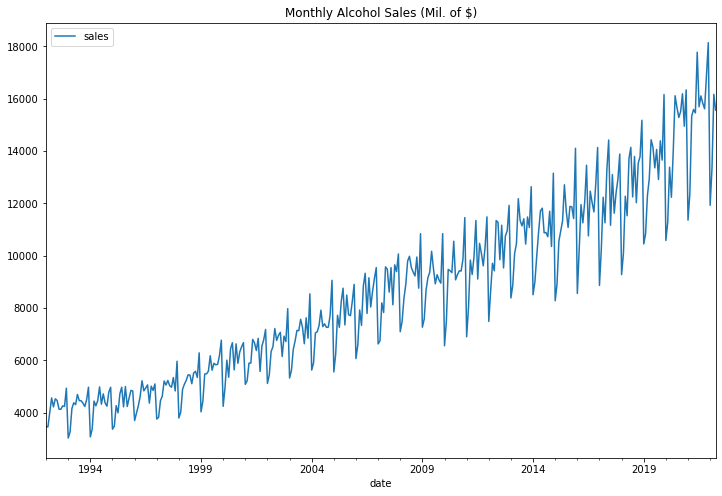

In [46]:
# plot series
df.plot(title='Monthly Alcohol Sales (Mil. of $)', figsize=(12, 8))
plt.show()

In [47]:
def create_lag_features(df, n_lags=12, drop_na=True):
    '''
    Create lagged features for each column in df.
    '''

    lagged_df = df.copy()

    for col in df.columns:
        for lag in np.arange(1, n_lags + 1):
            lagged_df[f'{col}_lag{lag}'] = lagged_df[col].shift(lag)

    return lagged_df.dropna() if drop_na else lagged_df


df = create_lag_features(df)
df.head()

,sales,sales_lag1,sales_lag2,sales_lag3,sales_lag4,sales_lag5,sales_lag6,sales_lag7,sales_lag8,sales_lag9,sales_lag10,sales_lag11,sales_lag12
date,,,,,,,,,,,,,
1993-01-01,3031,4936.0,4240.0,4259.0,4126.0,4137.0,4466.0,4529.0,4221.0,4564.0,4002.0,3458.0,3459.0
1993-02-01,3261,3031.0,4936.0,4240.0,4259.0,4126.0,4137.0,4466.0,4529.0,4221.0,4564.0,4002.0,3458.0
1993-03-01,4160,3261.0,3031.0,4936.0,4240.0,4259.0,4126.0,4137.0,4466.0,4529.0,4221.0,4564.0,4002.0
1993-04-01,4377,4160.0,3261.0,3031.0,4936.0,4240.0,4259.0,4126.0,4137.0,4466.0,4529.0,4221.0,4564.0
1993-05-01,4307,4377.0,4160.0,3261.0,3031.0,4936.0,4240.0,4259.0,4126.0,4137.0,4466.0,4529.0,4221.0


In [49]:
train = df.iloc[:-24, :]
test = df.iloc[-24:, :]

print(len(train), len(test))

328 24


In [56]:
X_train = train.drop('sales', axis=1).values
y_train = train['sales'].values
X_test = test.drop('sales', axis=1).values
y_test = test['sales'].values

model = XGBRegressor(n_estimators=1000)

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [63]:
test['sales_pred'] = model.predict(X_test)
test.head()

C:\Users\James\AppData\Local\Temp\ipykernel_17776\3023243136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['sales_pred'] = model.predict(X_test)


,sales,sales_lag1,sales_lag2,sales_lag3,sales_lag4,sales_lag5,sales_lag6,sales_lag7,sales_lag8,sales_lag9,sales_lag10,sales_lag11,sales_lag12,sales_pred
date,,,,,,,,,,,,,,
2020-05-01,13997,12232.0,13381.0,11267.0,10580.0,16158.0,13652.0,14389.0,12912.0,14058.0,13355.0,14145.0,14430.0,14491.722656
2020-06-01,16112,13997.0,12232.0,13381.0,11267.0,10580.0,16158.0,13652.0,14389.0,12912.0,14058.0,13355.0,14145.0,13879.662109
2020-07-01,15670,16112.0,13997.0,12232.0,13381.0,11267.0,10580.0,16158.0,13652.0,14389.0,12912.0,14058.0,13355.0,13365.712891
2020-08-01,15281,15670.0,16112.0,13997.0,12232.0,13381.0,11267.0,10580.0,16158.0,13652.0,14389.0,12912.0,14058.0,13308.786133
2020-09-01,15506,15281.0,15670.0,16112.0,13997.0,12232.0,13381.0,11267.0,10580.0,16158.0,13652.0,14389.0,12912.0,12973.867188


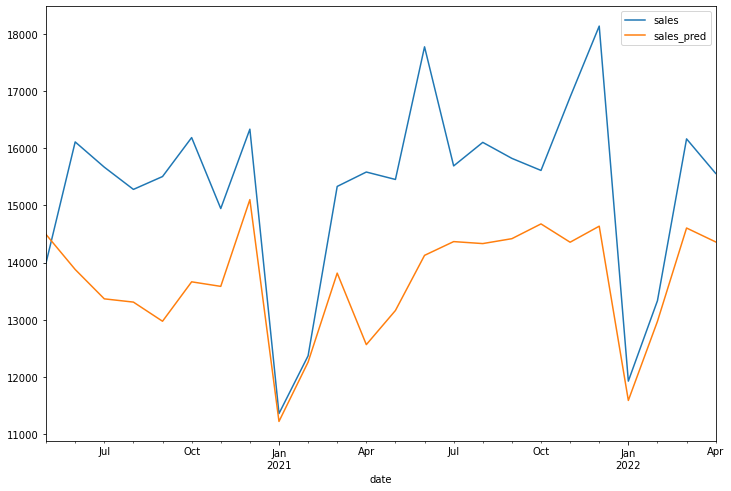

In [64]:
test[['sales', 'sales_pred']].plot(figsize=(12, 8))
plt.show()